<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/ALAD_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# from google.colab import drive
# drive.mount('/content/drive')

# ALAD - Toy examples

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection"
Credits : https://github.com/ChunyuanLI/ALICE

### Imports

In [90]:
%matplotlib inline
import os
import pdb
import sys
py_file_location = "/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection-master/toy_experiments/utils"
sys.path.append(os.path.abspath(py_file_location))

In [91]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from data_gmm import GMM_distribution, sample_GMM, plot_GMM
from data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

slim = tf.contrib.slim
ds = tf.contrib.distributions
graph_replace = tf.contrib.graph_editor.graph_replace

### Parameters

In [92]:
DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100

""" parameters """
n_epoch = 300
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [93]:
""" Create directory for results """
result_dir = '/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection-master/toy_experiments/results/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [94]:
""" Create dataset """

def four_five_gaussians(p1=1.0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],[-2, -2],[2, -2],[-2, 2],[0, 0]])
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]
    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    # gaussian_mixture = GMM_distribution(means=means_x,variances=variances_x,priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x

You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset

In [95]:
dataset_x = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_train.png'


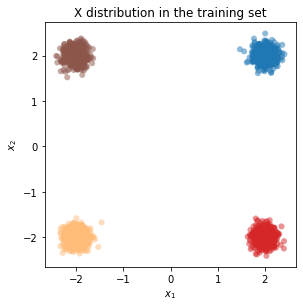

In [96]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

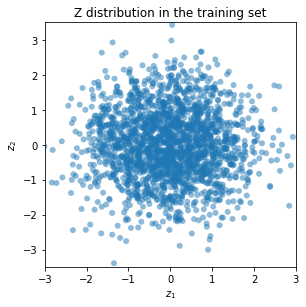

In [97]:
# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()

## Network

In [98]:
""" Networks """

def generative_network(z, input_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("generative", reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, input_dim, activation_fn=None)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim, reuse=False):
    with tf.variable_scope("inference", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None)      
    return z

def data_network_xz(x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
    """Approximate x log data density."""
    h = tf.concat([x,z], 1)
    with tf.variable_scope('discriminator', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_xx(x,x_hat, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([x,x_hat], 1)
    with tf.variable_scope('discriminator_xx', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

def data_network_zz(z, z_prime, n_layers=1, n_hidden=128, activation_fn=None, reuse=False):
    """Approximate x log data density."""
    # pdb.set_trace()
    h = tf.concat([z, z_prime], 1)
    with tf.variable_scope('discriminator_zz', reuse=reuse):
        h = slim.stack(h, slim.fully_connected, [n_hidden] * n_layers, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [99]:
""" Construct model and training ops """
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_dim))
z = tf.placeholder(tf.float32, shape=(None, latent_dim))

# decoder and encoder
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

decoder_logit = data_network_xz(p_x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit = graph_replace(decoder_logit, {p_x: x, z:q_z})

decoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(decoder_logit), logits=decoder_logit)
encoder_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(encoder_logit), logits=encoder_logit)

dis_loss_xz = tf.reduce_mean(encoder_loss) + tf.reduce_mean(decoder_loss)

rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)

x_logit_real = data_network_xx(x, x)
x_logit_fake = data_network_xx(x, rec_x, reuse=True)
z_logit_real = data_network_zz(z, z)
z_logit_fake = data_network_zz(z, rec_z,  reuse=True)

x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))

z_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.ones_like(z_logit_real))
z_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.zeros_like(z_logit_fake))

x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))


dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

cost_x = tf.reduce_mean(x_sigmoid_real2 + x_sigmoid_fake2) # + tf.reduce_mean(tf.pow(x_feature_real - x_feature_fake, 2))
cost_z = tf.reduce_mean(z_sigmoid_real2 + z_sigmoid_fake2) # + tf.reduce_mean(tf.pow(z_feature_real - z_feature_fake, 2))


decoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(decoder_logit), logits=decoder_logit)
encoder_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(encoder_logit), logits=encoder_logit)

gen_loss_xz = tf.reduce_mean(decoder_loss2)  + tf.reduce_mean(encoder_loss2)

gen_loss = gen_loss_xz + cost_x  + cost_z

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx + dvars_zz)

mahalanobis_dis_z = tf.norm(q_z, ord=2, axis=1, keep_dims=False, name='z_scores')

## Training

In [121]:
""" training """
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm(range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})
        
        FG.append(f_g)
        FD.append(f_d)
    print("\nepoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

  1%|          | 2/300 [00:00<01:34,  3.15it/s]


epoch 0 iter 2: discloss 4.286189 genloss 4.200796 adv_x 1.369043 recons_x 1.416610 

epoch 1 iter 2: discloss 4.207856 genloss 4.023044 adv_x 1.271747 recons_x 1.350051 


  1%|▏         | 4/300 [00:00<00:54,  5.40it/s]


epoch 2 iter 2: discloss 4.389888 genloss 4.387749 adv_x 1.351182 recons_x 1.543514 

epoch 3 iter 2: discloss 4.277232 genloss 4.090924 adv_x 1.148466 recons_x 1.618948 


  2%|▏         | 6/300 [00:01<00:43,  6.78it/s]


epoch 4 iter 2: discloss 4.267259 genloss 4.280917 adv_x 1.319062 recons_x 1.532556 

epoch 5 iter 2: discloss 4.407104 genloss 4.306218 adv_x 1.429012 recons_x 1.467403 


  3%|▎         | 8/300 [00:01<00:38,  7.54it/s]


epoch 6 iter 2: discloss 4.265565 genloss 4.183069 adv_x 1.351733 recons_x 1.423990 

epoch 7 iter 2: discloss 4.314400 genloss 4.145377 adv_x 1.317629 recons_x 1.426011 


  3%|▎         | 10/300 [00:01<00:35,  8.14it/s]


epoch 8 iter 2: discloss 4.308274 genloss 4.172726 adv_x 1.372995 recons_x 1.397614 

epoch 9 iter 2: discloss 4.125065 genloss 4.213804 adv_x 1.378040 recons_x 1.425137 


  4%|▍         | 12/300 [00:01<00:34,  8.40it/s]


epoch 10 iter 2: discloss 4.232280 genloss 4.182104 adv_x 1.393461 recons_x 1.388641 

epoch 11 iter 2: discloss 4.156583 genloss 4.189796 adv_x 1.392324 recons_x 1.389494 


  5%|▍         | 14/300 [00:02<00:35,  8.10it/s]


epoch 12 iter 2: discloss 4.124115 genloss 4.230070 adv_x 1.427692 recons_x 1.394884 

epoch 13 iter 2: discloss 4.130291 genloss 4.199832 adv_x 1.388039 recons_x 1.408629 


  5%|▌         | 16/300 [00:02<00:34,  8.15it/s]


epoch 14 iter 2: discloss 4.136199 genloss 4.194857 adv_x 1.410760 recons_x 1.385385 

epoch 15 iter 2: discloss 4.130558 genloss 4.201831 adv_x 1.413044 recons_x 1.386857 


  6%|▌         | 18/300 [00:02<00:33,  8.38it/s]


epoch 16 iter 2: discloss 4.122296 genloss 4.201113 adv_x 1.406695 recons_x 1.387200 

epoch 17 iter 2: discloss 4.120850 genloss 4.203447 adv_x 1.408965 recons_x 1.386161 


  7%|▋         | 20/300 [00:02<00:33,  8.45it/s]


epoch 18 iter 2: discloss 4.116216 genloss 4.205940 adv_x 1.412345 recons_x 1.386771 

epoch 19 iter 2: discloss 4.118891 genloss 4.211190 adv_x 1.408335 recons_x 1.392253 


  7%|▋         | 22/300 [00:03<00:33,  8.38it/s]


epoch 20 iter 2: discloss 4.099233 genloss 4.216598 adv_x 1.409696 recons_x 1.389961 

epoch 21 iter 2: discloss 4.113999 genloss 4.214530 adv_x 1.414533 recons_x 1.388259 


  8%|▊         | 24/300 [00:03<00:32,  8.47it/s]


epoch 22 iter 2: discloss 4.136917 genloss 4.221475 adv_x 1.411350 recons_x 1.398819 

epoch 23 iter 2: discloss 4.110335 genloss 4.223870 adv_x 1.398241 recons_x 1.409418 


  9%|▊         | 26/300 [00:03<00:32,  8.49it/s]


epoch 24 iter 2: discloss 4.166023 genloss 4.210189 adv_x 1.409547 recons_x 1.390025 

epoch 25 iter 2: discloss 4.124023 genloss 4.220277 adv_x 1.426635 recons_x 1.389096 


  9%|▉         | 28/300 [00:03<00:32,  8.30it/s]


epoch 26 iter 2: discloss 4.194258 genloss 4.206624 adv_x 1.399257 recons_x 1.399659 

epoch 27 iter 2: discloss 4.136141 genloss 4.206811 adv_x 1.407739 recons_x 1.389055 


 10%|█         | 30/300 [00:04<00:32,  8.42it/s]


epoch 28 iter 2: discloss 4.116163 genloss 4.229013 adv_x 1.432699 recons_x 1.394834 

epoch 29 iter 2: discloss 4.143812 genloss 4.186980 adv_x 1.385333 recons_x 1.399625 


 11%|█         | 32/300 [00:04<00:32,  8.31it/s]


epoch 30 iter 2: discloss 4.133958 genloss 4.204356 adv_x 1.412897 recons_x 1.386481 

epoch 31 iter 2: discloss 4.122358 genloss 4.199782 adv_x 1.415784 recons_x 1.386486 


 11%|█▏        | 34/300 [00:04<00:31,  8.46it/s]


epoch 32 iter 2: discloss 4.115401 genloss 4.208612 adv_x 1.369628 recons_x 1.422976 

epoch 33 iter 2: discloss 4.142318 genloss 4.206566 adv_x 1.400825 recons_x 1.399631 


 12%|█▏        | 36/300 [00:04<00:30,  8.53it/s]


epoch 34 iter 2: discloss 4.106116 genloss 4.215532 adv_x 1.396933 recons_x 1.396538 

epoch 35 iter 2: discloss 4.126390 genloss 4.202022 adv_x 1.387817 recons_x 1.395525 


 13%|█▎        | 38/300 [00:05<00:31,  8.45it/s]


epoch 36 iter 2: discloss 4.121502 genloss 4.201479 adv_x 1.400348 recons_x 1.394210 

epoch 37 iter 2: discloss 4.107575 genloss 4.221748 adv_x 1.406982 recons_x 1.399603 


 13%|█▎        | 40/300 [00:05<00:30,  8.52it/s]


epoch 38 iter 2: discloss 4.120138 genloss 4.192263 adv_x 1.399182 recons_x 1.390579 

epoch 39 iter 2: discloss 4.137549 genloss 4.195421 adv_x 1.403054 recons_x 1.392948 


 14%|█▍        | 42/300 [00:05<00:30,  8.40it/s]


epoch 40 iter 2: discloss 4.127104 genloss 4.202648 adv_x 1.414951 recons_x 1.387566 

epoch 41 iter 2: discloss 4.134155 genloss 4.190291 adv_x 1.398735 recons_x 1.387224 


 15%|█▍        | 44/300 [00:05<00:30,  8.47it/s]


epoch 42 iter 2: discloss 4.136416 genloss 4.226251 adv_x 1.406228 recons_x 1.405897 

epoch 43 iter 2: discloss 4.105382 genloss 4.209952 adv_x 1.411907 recons_x 1.390143 


 15%|█▌        | 46/300 [00:05<00:29,  8.48it/s]


epoch 44 iter 2: discloss 4.148959 genloss 4.234419 adv_x 1.395692 recons_x 1.408620 

epoch 45 iter 2: discloss 4.108228 genloss 4.216714 adv_x 1.358621 recons_x 1.438819 


 16%|█▌        | 48/300 [00:06<00:29,  8.43it/s]


epoch 46 iter 2: discloss 4.099871 genloss 4.216776 adv_x 1.420892 recons_x 1.388164 

epoch 47 iter 2: discloss 4.127496 genloss 4.205027 adv_x 1.371466 recons_x 1.417216 


 17%|█▋        | 50/300 [00:06<00:29,  8.46it/s]


epoch 48 iter 2: discloss 4.132528 genloss 4.211418 adv_x 1.387822 recons_x 1.409935 

epoch 49 iter 2: discloss 4.121647 genloss 4.213823 adv_x 1.417921 recons_x 1.386775 


 17%|█▋        | 52/300 [00:06<00:29,  8.41it/s]


epoch 50 iter 2: discloss 4.128348 genloss 4.202848 adv_x 1.408903 recons_x 1.390861 

epoch 51 iter 2: discloss 4.108081 genloss 4.203819 adv_x 1.413674 recons_x 1.389747 


 18%|█▊        | 54/300 [00:06<00:28,  8.52it/s]


epoch 52 iter 2: discloss 4.113128 genloss 4.236860 adv_x 1.404777 recons_x 1.402254 

epoch 53 iter 2: discloss 4.099512 genloss 4.211300 adv_x 1.409913 recons_x 1.395470 


 19%|█▊        | 56/300 [00:07<00:28,  8.50it/s]


epoch 54 iter 2: discloss 4.093607 genloss 4.215676 adv_x 1.409131 recons_x 1.396360 

epoch 55 iter 2: discloss 4.159809 genloss 4.196486 adv_x 1.378134 recons_x 1.401751 


 19%|█▉        | 58/300 [00:07<00:28,  8.39it/s]


epoch 56 iter 2: discloss 4.133748 genloss 4.210572 adv_x 1.411869 recons_x 1.388494 

epoch 57 iter 2: discloss 4.101427 genloss 4.209991 adv_x 1.412044 recons_x 1.389914 


 20%|██        | 60/300 [00:07<00:28,  8.43it/s]


epoch 58 iter 2: discloss 4.128272 genloss 4.206138 adv_x 1.391900 recons_x 1.392450 

epoch 59 iter 2: discloss 4.107716 genloss 4.196024 adv_x 1.359654 recons_x 1.423110 


 21%|██        | 62/300 [00:07<00:28,  8.47it/s]


epoch 60 iter 2: discloss 4.095435 genloss 4.215414 adv_x 1.423018 recons_x 1.385731 

epoch 61 iter 2: discloss 4.123717 genloss 4.204988 adv_x 1.408093 recons_x 1.388710 


 21%|██▏       | 64/300 [00:08<00:27,  8.50it/s]


epoch 62 iter 2: discloss 4.122221 genloss 4.208441 adv_x 1.396082 recons_x 1.398085 

epoch 63 iter 2: discloss 4.105152 genloss 4.225114 adv_x 1.410632 recons_x 1.394108 


 22%|██▏       | 66/300 [00:08<00:27,  8.48it/s]


epoch 64 iter 2: discloss 4.083443 genloss 4.203957 adv_x 1.407142 recons_x 1.390892 

epoch 65 iter 2: discloss 4.108648 genloss 4.238376 adv_x 1.417300 recons_x 1.395006 


 23%|██▎       | 68/300 [00:08<00:27,  8.45it/s]


epoch 66 iter 2: discloss 4.101867 genloss 4.208175 adv_x 1.401091 recons_x 1.395920 

epoch 67 iter 2: discloss 4.105398 genloss 4.222549 adv_x 1.414495 recons_x 1.393021 


 23%|██▎       | 70/300 [00:08<00:27,  8.22it/s]


epoch 68 iter 2: discloss 4.100340 genloss 4.225139 adv_x 1.412448 recons_x 1.395014 

epoch 69 iter 2: discloss 4.104645 genloss 4.221377 adv_x 1.420385 recons_x 1.391814 


 24%|██▍       | 72/300 [00:09<00:27,  8.33it/s]


epoch 70 iter 2: discloss 4.099275 genloss 4.214141 adv_x 1.402706 recons_x 1.393617 

epoch 71 iter 2: discloss 4.098368 genloss 4.250409 adv_x 1.423798 recons_x 1.395454 


 25%|██▍       | 74/300 [00:09<00:27,  8.34it/s]


epoch 72 iter 2: discloss 4.108580 genloss 4.238114 adv_x 1.421386 recons_x 1.395349 

epoch 73 iter 2: discloss 4.125464 genloss 4.225598 adv_x 1.414725 recons_x 1.398190 


 25%|██▌       | 76/300 [00:09<00:27,  8.29it/s]


epoch 74 iter 2: discloss 4.097239 genloss 4.233703 adv_x 1.432990 recons_x 1.388892 

epoch 75 iter 2: discloss 4.111403 genloss 4.225860 adv_x 1.428499 recons_x 1.390903 


 26%|██▌       | 78/300 [00:09<00:26,  8.33it/s]


epoch 76 iter 2: discloss 4.098462 genloss 4.248979 adv_x 1.439609 recons_x 1.393160 

epoch 77 iter 2: discloss 4.108745 genloss 4.241253 adv_x 1.435861 recons_x 1.390411 


 27%|██▋       | 80/300 [00:10<00:26,  8.35it/s]


epoch 78 iter 2: discloss 4.095968 genloss 4.255031 adv_x 1.397336 recons_x 1.407118 

epoch 79 iter 2: discloss 4.098691 genloss 4.264399 adv_x 1.454628 recons_x 1.387713 


 27%|██▋       | 82/300 [00:10<00:26,  8.19it/s]


epoch 80 iter 2: discloss 4.105215 genloss 4.257752 adv_x 1.440036 recons_x 1.387489 

epoch 81 iter 2: discloss 4.087724 genloss 4.262729 adv_x 1.422333 recons_x 1.404711 


 28%|██▊       | 84/300 [00:10<00:25,  8.31it/s]


epoch 82 iter 2: discloss 4.065723 genloss 4.278861 adv_x 1.462766 recons_x 1.392165 

epoch 83 iter 2: discloss 4.095492 genloss 4.260134 adv_x 1.437031 recons_x 1.396173 


 29%|██▊       | 86/300 [00:10<00:25,  8.28it/s]


epoch 84 iter 2: discloss 4.087514 genloss 4.273367 adv_x 1.447766 recons_x 1.400033 

epoch 85 iter 2: discloss 4.081244 genloss 4.283710 adv_x 1.450815 recons_x 1.394329 


 29%|██▉       | 88/300 [00:10<00:25,  8.34it/s]


epoch 86 iter 2: discloss 4.043414 genloss 4.291031 adv_x 1.465671 recons_x 1.394579 

epoch 87 iter 2: discloss 4.089080 genloss 4.284098 adv_x 1.460536 recons_x 1.392302 


 30%|███       | 90/300 [00:11<00:25,  8.17it/s]


epoch 88 iter 2: discloss 4.062559 genloss 4.282645 adv_x 1.465525 recons_x 1.391802 

epoch 89 iter 2: discloss 4.066731 genloss 4.280878 adv_x 1.459568 recons_x 1.394793 


 31%|███       | 92/300 [00:11<00:25,  8.17it/s]


epoch 90 iter 2: discloss 4.055851 genloss 4.316374 adv_x 1.482799 recons_x 1.389114 

epoch 91 iter 2: discloss 4.051763 genloss 4.314789 adv_x 1.472092 recons_x 1.390308 


 31%|███▏      | 94/300 [00:11<00:24,  8.30it/s]


epoch 92 iter 2: discloss 4.052838 genloss 4.313184 adv_x 1.467815 recons_x 1.393096 

epoch 93 iter 2: discloss 4.053319 genloss 4.299883 adv_x 1.465736 recons_x 1.391043 


 32%|███▏      | 96/300 [00:11<00:24,  8.34it/s]


epoch 94 iter 2: discloss 4.047563 genloss 4.336409 adv_x 1.491409 recons_x 1.393548 

epoch 95 iter 2: discloss 4.037774 genloss 4.322435 adv_x 1.485674 recons_x 1.394987 


 33%|███▎      | 98/300 [00:12<00:24,  8.21it/s]


epoch 96 iter 2: discloss 4.022444 genloss 4.325207 adv_x 1.464858 recons_x 1.398688 

epoch 97 iter 2: discloss 4.030481 genloss 4.298325 adv_x 1.488811 recons_x 1.386778 


 33%|███▎      | 100/300 [00:12<00:24,  8.12it/s]


epoch 98 iter 2: discloss 4.059926 genloss 4.314833 adv_x 1.461290 recons_x 1.399174 

epoch 99 iter 2: discloss 4.052236 genloss 4.321748 adv_x 1.480070 recons_x 1.403750 


 34%|███▍      | 102/300 [00:12<00:24,  8.19it/s]


epoch 100 iter 2: discloss 4.047963 genloss 4.262792 adv_x 1.395339 recons_x 1.401033 

epoch 101 iter 2: discloss 4.012832 genloss 4.365314 adv_x 1.419856 recons_x 1.465388 


 35%|███▍      | 104/300 [00:12<00:23,  8.36it/s]


epoch 102 iter 2: discloss 4.096567 genloss 4.332593 adv_x 1.450326 recons_x 1.419668 

epoch 103 iter 2: discloss 4.097313 genloss 4.285785 adv_x 1.459236 recons_x 1.387357 


 35%|███▌      | 106/300 [00:13<00:23,  8.33it/s]


epoch 104 iter 2: discloss 4.079237 genloss 4.337560 adv_x 1.508970 recons_x 1.389659 

epoch 105 iter 2: discloss 4.104201 genloss 4.288607 adv_x 1.429418 recons_x 1.409255 


 36%|███▌      | 108/300 [00:13<00:23,  8.25it/s]


epoch 106 iter 2: discloss 3.998980 genloss 4.309597 adv_x 1.473004 recons_x 1.400514 

epoch 107 iter 2: discloss 4.088998 genloss 4.326309 adv_x 1.474841 recons_x 1.395235 


 37%|███▋      | 110/300 [00:13<00:22,  8.42it/s]


epoch 108 iter 2: discloss 4.082451 genloss 4.294044 adv_x 1.456728 recons_x 1.394383 

epoch 109 iter 2: discloss 4.032819 genloss 4.345821 adv_x 1.507432 recons_x 1.391639 


 37%|███▋      | 112/300 [00:13<00:22,  8.31it/s]


epoch 110 iter 2: discloss 4.039678 genloss 4.304152 adv_x 1.443961 recons_x 1.394702 

epoch 111 iter 2: discloss 4.041443 genloss 4.335567 adv_x 1.477030 recons_x 1.400271 


 38%|███▊      | 114/300 [00:14<00:22,  8.30it/s]


epoch 112 iter 2: discloss 4.048444 genloss 4.324724 adv_x 1.484357 recons_x 1.391894 

epoch 113 iter 2: discloss 4.034563 genloss 4.327641 adv_x 1.458425 recons_x 1.390785 


 39%|███▊      | 116/300 [00:14<00:22,  8.32it/s]


epoch 114 iter 2: discloss 4.027976 genloss 4.366747 adv_x 1.511719 recons_x 1.411939 

epoch 115 iter 2: discloss 4.111342 genloss 4.330864 adv_x 1.424677 recons_x 1.415869 


 39%|███▉      | 118/300 [00:14<00:22,  8.25it/s]


epoch 116 iter 2: discloss 4.040369 genloss 4.342666 adv_x 1.501455 recons_x 1.388753 

epoch 117 iter 2: discloss 4.045125 genloss 4.357419 adv_x 1.509028 recons_x 1.396001 


 40%|████      | 120/300 [00:14<00:21,  8.27it/s]


epoch 118 iter 2: discloss 4.044138 genloss 4.378987 adv_x 1.487656 recons_x 1.392008 

epoch 119 iter 2: discloss 4.060150 genloss 4.283488 adv_x 1.433198 recons_x 1.398663 


 41%|████      | 122/300 [00:15<00:21,  8.36it/s]


epoch 120 iter 2: discloss 4.017755 genloss 4.344721 adv_x 1.475024 recons_x 1.392367 

epoch 121 iter 2: discloss 4.018380 genloss 4.340102 adv_x 1.463622 recons_x 1.387464 


 41%|████▏     | 124/300 [00:15<00:21,  8.17it/s]


epoch 122 iter 2: discloss 4.076869 genloss 4.322367 adv_x 1.380302 recons_x 1.456891 

epoch 123 iter 2: discloss 4.085733 genloss 4.342463 adv_x 1.503160 recons_x 1.388961 


 42%|████▏     | 126/300 [00:15<00:21,  8.22it/s]


epoch 124 iter 2: discloss 4.030979 genloss 4.314475 adv_x 1.464554 recons_x 1.392568 

epoch 125 iter 2: discloss 4.061304 genloss 4.360857 adv_x 1.505093 recons_x 1.395677 


 43%|████▎     | 128/300 [00:15<00:21,  8.10it/s]


epoch 126 iter 2: discloss 3.996595 genloss 4.277110 adv_x 1.418590 recons_x 1.404049 

epoch 127 iter 2: discloss 4.094588 genloss 4.301596 adv_x 1.457724 recons_x 1.392177 


 43%|████▎     | 130/300 [00:16<00:20,  8.14it/s]


epoch 128 iter 2: discloss 3.973182 genloss 4.337138 adv_x 1.476049 recons_x 1.395270 

epoch 129 iter 2: discloss 4.029696 genloss 4.308134 adv_x 1.476326 recons_x 1.393702 


 44%|████▍     | 132/300 [00:16<00:20,  8.12it/s]


epoch 130 iter 2: discloss 4.037920 genloss 4.372317 adv_x 1.477657 recons_x 1.395756 

epoch 131 iter 2: discloss 4.083265 genloss 4.325315 adv_x 1.486707 recons_x 1.391047 


 45%|████▍     | 134/300 [00:16<00:20,  8.23it/s]


epoch 132 iter 2: discloss 3.973914 genloss 4.378494 adv_x 1.429388 recons_x 1.435712 

epoch 133 iter 2: discloss 4.064386 genloss 4.375844 adv_x 1.481971 recons_x 1.406613 


 45%|████▌     | 136/300 [00:16<00:20,  8.04it/s]


epoch 134 iter 2: discloss 3.955461 genloss 4.369358 adv_x 1.499673 recons_x 1.393445 

epoch 135 iter 2: discloss 4.036577 genloss 4.358675 adv_x 1.483254 recons_x 1.391881 


 46%|████▌     | 138/300 [00:17<00:20,  8.10it/s]


epoch 136 iter 2: discloss 3.966522 genloss 4.313139 adv_x 1.438704 recons_x 1.386076 

epoch 137 iter 2: discloss 4.063012 genloss 4.476501 adv_x 1.581569 recons_x 1.399932 


 47%|████▋     | 140/300 [00:17<00:19,  8.23it/s]


epoch 138 iter 2: discloss 3.971385 genloss 4.337713 adv_x 1.443763 recons_x 1.389516 

epoch 139 iter 2: discloss 4.132323 genloss 4.283937 adv_x 1.418798 recons_x 1.392347 


 47%|████▋     | 142/300 [00:17<00:19,  8.25it/s]


epoch 140 iter 2: discloss 4.139647 genloss 4.276269 adv_x 1.431635 recons_x 1.381285 

epoch 141 iter 2: discloss 4.048740 genloss 4.381168 adv_x 1.492663 recons_x 1.431856 


 48%|████▊     | 144/300 [00:17<00:18,  8.26it/s]


epoch 142 iter 2: discloss 4.032619 genloss 4.341824 adv_x 1.455406 recons_x 1.394225 

epoch 143 iter 2: discloss 4.084185 genloss 4.321161 adv_x 1.439490 recons_x 1.389295 


 49%|████▊     | 146/300 [00:18<00:18,  8.35it/s]


epoch 144 iter 2: discloss 4.049641 genloss 4.314671 adv_x 1.450052 recons_x 1.390724 

epoch 145 iter 2: discloss 4.032834 genloss 4.339903 adv_x 1.490633 recons_x 1.393765 


 49%|████▉     | 148/300 [00:18<00:18,  8.33it/s]


epoch 146 iter 2: discloss 4.071107 genloss 4.348420 adv_x 1.419552 recons_x 1.394040 

epoch 147 iter 2: discloss 4.058439 genloss 4.318234 adv_x 1.400415 recons_x 1.409887 


 50%|█████     | 150/300 [00:18<00:17,  8.37it/s]


epoch 148 iter 2: discloss 4.075242 genloss 4.356656 adv_x 1.467500 recons_x 1.383040 

epoch 149 iter 2: discloss 3.997149 genloss 4.313743 adv_x 1.462226 recons_x 1.388302 


 51%|█████     | 152/300 [00:18<00:17,  8.39it/s]


epoch 150 iter 2: discloss 4.055569 genloss 4.379585 adv_x 1.467010 recons_x 1.393795 

epoch 151 iter 2: discloss 3.989638 genloss 4.411056 adv_x 1.481795 recons_x 1.399207 


 51%|█████▏    | 154/300 [00:18<00:17,  8.35it/s]


epoch 152 iter 2: discloss 4.038600 genloss 4.332523 adv_x 1.480106 recons_x 1.387434 

epoch 153 iter 2: discloss 3.995311 genloss 4.323832 adv_x 1.451598 recons_x 1.389655 


 52%|█████▏    | 156/300 [00:19<00:17,  8.26it/s]


epoch 154 iter 2: discloss 3.996765 genloss 4.350784 adv_x 1.483085 recons_x 1.389877 

epoch 155 iter 2: discloss 3.989105 genloss 4.337854 adv_x 1.458565 recons_x 1.417943 


 53%|█████▎    | 158/300 [00:19<00:17,  8.22it/s]


epoch 156 iter 2: discloss 3.998644 genloss 4.439665 adv_x 1.445793 recons_x 1.394771 

epoch 157 iter 2: discloss 4.027783 genloss 4.359090 adv_x 1.450253 recons_x 1.391217 


 53%|█████▎    | 160/300 [00:19<00:16,  8.29it/s]


epoch 158 iter 2: discloss 3.985874 genloss 4.361530 adv_x 1.469867 recons_x 1.389848 

epoch 159 iter 2: discloss 4.009609 genloss 4.341586 adv_x 1.456586 recons_x 1.395686 


 54%|█████▍    | 162/300 [00:19<00:16,  8.37it/s]


epoch 160 iter 2: discloss 3.994348 genloss 4.400289 adv_x 1.456018 recons_x 1.412390 

epoch 161 iter 2: discloss 3.946426 genloss 4.420545 adv_x 1.521717 recons_x 1.393976 


 55%|█████▍    | 164/300 [00:20<00:16,  8.48it/s]


epoch 162 iter 2: discloss 3.968759 genloss 4.408270 adv_x 1.488424 recons_x 1.396639 

epoch 163 iter 2: discloss 3.968257 genloss 4.364596 adv_x 1.504818 recons_x 1.384328 


 55%|█████▌    | 166/300 [00:20<00:16,  8.34it/s]


epoch 164 iter 2: discloss 4.042648 genloss 4.345542 adv_x 1.443008 recons_x 1.389996 

epoch 165 iter 2: discloss 3.968945 genloss 4.414252 adv_x 1.539873 recons_x 1.393436 


 56%|█████▌    | 168/300 [00:20<00:15,  8.27it/s]


epoch 166 iter 2: discloss 3.973310 genloss 4.384262 adv_x 1.470137 recons_x 1.394909 

epoch 167 iter 2: discloss 3.999940 genloss 4.409066 adv_x 1.534015 recons_x 1.385042 


 57%|█████▋    | 170/300 [00:20<00:15,  8.41it/s]


epoch 168 iter 2: discloss 4.019011 genloss 4.321067 adv_x 1.411803 recons_x 1.389217 

epoch 169 iter 2: discloss 3.979894 genloss 4.438664 adv_x 1.462295 recons_x 1.423676 


 57%|█████▋    | 172/300 [00:21<00:15,  8.34it/s]


epoch 170 iter 2: discloss 3.983538 genloss 4.350303 adv_x 1.466051 recons_x 1.391038 

epoch 171 iter 2: discloss 4.018519 genloss 4.422327 adv_x 1.473148 recons_x 1.388039 


 58%|█████▊    | 174/300 [00:21<00:15,  8.37it/s]


epoch 172 iter 2: discloss 3.998294 genloss 4.387791 adv_x 1.445138 recons_x 1.410164 

epoch 173 iter 2: discloss 4.016913 genloss 4.346944 adv_x 1.488293 recons_x 1.385283 


 59%|█████▊    | 176/300 [00:21<00:14,  8.30it/s]


epoch 174 iter 2: discloss 3.944422 genloss 4.392138 adv_x 1.505513 recons_x 1.390131 

epoch 175 iter 2: discloss 3.946825 genloss 4.404900 adv_x 1.502027 recons_x 1.393119 


 59%|█████▉    | 178/300 [00:21<00:14,  8.27it/s]


epoch 176 iter 2: discloss 3.982703 genloss 4.436895 adv_x 1.492292 recons_x 1.403219 

epoch 177 iter 2: discloss 3.982906 genloss 4.381681 adv_x 1.463050 recons_x 1.392966 


 60%|██████    | 180/300 [00:22<00:14,  8.32it/s]


epoch 178 iter 2: discloss 3.998010 genloss 4.397085 adv_x 1.432081 recons_x 1.409154 

epoch 179 iter 2: discloss 3.996842 genloss 4.385836 adv_x 1.522425 recons_x 1.387203 


 61%|██████    | 182/300 [00:22<00:14,  8.29it/s]


epoch 180 iter 2: discloss 4.009224 genloss 4.388314 adv_x 1.501117 recons_x 1.387569 

epoch 181 iter 2: discloss 4.010072 genloss 4.468112 adv_x 1.473028 recons_x 1.387877 


 61%|██████▏   | 184/300 [00:22<00:13,  8.38it/s]


epoch 182 iter 2: discloss 3.911004 genloss 4.438749 adv_x 1.512442 recons_x 1.395327 

epoch 183 iter 2: discloss 3.942959 genloss 4.403782 adv_x 1.473679 recons_x 1.397770 


 62%|██████▏   | 186/300 [00:22<00:13,  8.29it/s]


epoch 184 iter 2: discloss 3.990810 genloss 4.384829 adv_x 1.480897 recons_x 1.390592 

epoch 185 iter 2: discloss 3.955224 genloss 4.405111 adv_x 1.509034 recons_x 1.391809 


 63%|██████▎   | 188/300 [00:23<00:13,  8.31it/s]


epoch 186 iter 2: discloss 4.034353 genloss 4.386206 adv_x 1.452723 recons_x 1.411403 

epoch 187 iter 2: discloss 4.002545 genloss 4.439392 adv_x 1.516563 recons_x 1.412890 


 63%|██████▎   | 190/300 [00:23<00:13,  8.33it/s]


epoch 188 iter 2: discloss 3.907225 genloss 4.401466 adv_x 1.483564 recons_x 1.398050 

epoch 189 iter 2: discloss 4.061419 genloss 4.464559 adv_x 1.502911 recons_x 1.386484 


 64%|██████▍   | 192/300 [00:23<00:13,  8.23it/s]


epoch 190 iter 2: discloss 4.003694 genloss 4.471151 adv_x 1.565274 recons_x 1.391043 

epoch 191 iter 2: discloss 4.006143 genloss 4.412571 adv_x 1.459804 recons_x 1.394677 


 65%|██████▍   | 194/300 [00:23<00:12,  8.28it/s]


epoch 192 iter 2: discloss 4.004326 genloss 4.314032 adv_x 1.423032 recons_x 1.397196 

epoch 193 iter 2: discloss 4.090654 genloss 4.326916 adv_x 1.469014 recons_x 1.385017 


 65%|██████▌   | 196/300 [00:24<00:12,  8.42it/s]


epoch 194 iter 2: discloss 3.935323 genloss 4.526772 adv_x 1.564387 recons_x 1.389869 

epoch 195 iter 2: discloss 3.928407 genloss 4.530636 adv_x 1.528246 recons_x 1.398996 


 66%|██████▌   | 198/300 [00:24<00:12,  8.32it/s]


epoch 196 iter 2: discloss 3.945645 genloss 4.431154 adv_x 1.501535 recons_x 1.397882 

epoch 197 iter 2: discloss 4.022507 genloss 4.434729 adv_x 1.449272 recons_x 1.386854 


 67%|██████▋   | 200/300 [00:24<00:12,  8.31it/s]


epoch 198 iter 2: discloss 4.036775 genloss 4.380191 adv_x 1.486206 recons_x 1.391003 

epoch 199 iter 2: discloss 4.042917 genloss 4.419261 adv_x 1.458270 recons_x 1.392305 


 67%|██████▋   | 202/300 [00:24<00:11,  8.38it/s]


epoch 200 iter 2: discloss 4.007789 genloss 4.485333 adv_x 1.541957 recons_x 1.397352 

epoch 201 iter 2: discloss 3.994863 genloss 4.469154 adv_x 1.548966 recons_x 1.392004 


 68%|██████▊   | 204/300 [00:25<00:11,  8.34it/s]


epoch 202 iter 2: discloss 4.035882 genloss 4.400721 adv_x 1.463284 recons_x 1.381058 

epoch 203 iter 2: discloss 3.955084 genloss 4.471473 adv_x 1.550666 recons_x 1.380989 


 69%|██████▊   | 206/300 [00:25<00:11,  8.27it/s]


epoch 204 iter 2: discloss 3.907743 genloss 4.492344 adv_x 1.502395 recons_x 1.407944 

epoch 205 iter 2: discloss 3.907009 genloss 4.367521 adv_x 1.482782 recons_x 1.396226 


 69%|██████▉   | 208/300 [00:25<00:11,  8.23it/s]


epoch 206 iter 2: discloss 4.010071 genloss 4.485413 adv_x 1.495985 recons_x 1.392201 

epoch 207 iter 2: discloss 3.949649 genloss 4.365874 adv_x 1.482496 recons_x 1.386429 


 70%|███████   | 210/300 [00:25<00:10,  8.25it/s]


epoch 208 iter 2: discloss 3.983505 genloss 4.535367 adv_x 1.521705 recons_x 1.391331 

epoch 209 iter 2: discloss 3.881446 genloss 4.654893 adv_x 1.620328 recons_x 1.401416 


 71%|███████   | 212/300 [00:25<00:10,  8.28it/s]


epoch 210 iter 2: discloss 3.960903 genloss 4.342301 adv_x 1.430914 recons_x 1.399408 

epoch 211 iter 2: discloss 4.076309 genloss 4.375904 adv_x 1.411727 recons_x 1.388490 


 71%|███████▏  | 214/300 [00:26<00:10,  8.30it/s]


epoch 212 iter 2: discloss 4.053786 genloss 4.413447 adv_x 1.478814 recons_x 1.395064 

epoch 213 iter 2: discloss 3.942266 genloss 4.486612 adv_x 1.545803 recons_x 1.389977 


 72%|███████▏  | 216/300 [00:26<00:10,  8.30it/s]


epoch 214 iter 2: discloss 3.930369 genloss 4.455313 adv_x 1.508802 recons_x 1.403153 

epoch 215 iter 2: discloss 3.929521 genloss 4.552141 adv_x 1.540449 recons_x 1.402423 


 73%|███████▎  | 218/300 [00:26<00:10,  8.10it/s]


epoch 216 iter 2: discloss 3.946134 genloss 4.471287 adv_x 1.503514 recons_x 1.391439 

epoch 217 iter 2: discloss 4.026474 genloss 4.408139 adv_x 1.458114 recons_x 1.394468 


 73%|███████▎  | 220/300 [00:26<00:09,  8.15it/s]


epoch 218 iter 2: discloss 3.917786 genloss 4.462723 adv_x 1.487658 recons_x 1.387588 

epoch 219 iter 2: discloss 3.989276 genloss 4.572277 adv_x 1.503783 recons_x 1.399468 


 74%|███████▍  | 222/300 [00:27<00:09,  8.19it/s]


epoch 220 iter 2: discloss 3.920801 genloss 4.540104 adv_x 1.567337 recons_x 1.385693 

epoch 221 iter 2: discloss 3.891645 genloss 4.383815 adv_x 1.511085 recons_x 1.387041 


 75%|███████▍  | 224/300 [00:27<00:09,  8.17it/s]


epoch 222 iter 2: discloss 3.962310 genloss 4.466770 adv_x 1.501755 recons_x 1.402476 

epoch 223 iter 2: discloss 3.952995 genloss 4.459466 adv_x 1.519364 recons_x 1.404951 


 75%|███████▌  | 226/300 [00:27<00:09,  8.22it/s]


epoch 224 iter 2: discloss 3.860971 genloss 4.519627 adv_x 1.540833 recons_x 1.391778 

epoch 225 iter 2: discloss 3.931820 genloss 4.519649 adv_x 1.547603 recons_x 1.394917 


 76%|███████▌  | 228/300 [00:27<00:08,  8.40it/s]


epoch 226 iter 2: discloss 3.897075 genloss 4.465159 adv_x 1.524037 recons_x 1.393658 

epoch 227 iter 2: discloss 4.071763 genloss 4.415886 adv_x 1.453023 recons_x 1.394638 


 77%|███████▋  | 230/300 [00:28<00:08,  8.28it/s]


epoch 228 iter 2: discloss 3.958275 genloss 4.415502 adv_x 1.520887 recons_x 1.394693 

epoch 229 iter 2: discloss 3.883024 genloss 4.471751 adv_x 1.535872 recons_x 1.386299 


 77%|███████▋  | 232/300 [00:28<00:08,  8.26it/s]


epoch 230 iter 2: discloss 3.943527 genloss 4.555426 adv_x 1.502489 recons_x 1.399717 

epoch 231 iter 2: discloss 3.975464 genloss 4.602788 adv_x 1.563836 recons_x 1.392567 


 78%|███████▊  | 234/300 [00:28<00:08,  8.15it/s]


epoch 232 iter 2: discloss 3.879170 genloss 4.517079 adv_x 1.580041 recons_x 1.386652 

epoch 233 iter 2: discloss 3.935892 genloss 4.484819 adv_x 1.511194 recons_x 1.392686 


 79%|███████▊  | 236/300 [00:28<00:07,  8.27it/s]


epoch 234 iter 2: discloss 3.969436 genloss 4.553211 adv_x 1.507057 recons_x 1.388349 

epoch 235 iter 2: discloss 3.958458 genloss 4.510207 adv_x 1.474011 recons_x 1.397578 


 79%|███████▉  | 238/300 [00:29<00:07,  8.18it/s]


epoch 236 iter 2: discloss 3.928917 genloss 4.365832 adv_x 1.513442 recons_x 1.388872 

epoch 237 iter 2: discloss 3.952590 genloss 4.567968 adv_x 1.566368 recons_x 1.393878 


 80%|████████  | 240/300 [00:29<00:07,  8.34it/s]


epoch 238 iter 2: discloss 3.914449 genloss 4.553897 adv_x 1.579845 recons_x 1.406447 

epoch 239 iter 2: discloss 3.927597 genloss 4.566006 adv_x 1.526566 recons_x 1.395363 


 81%|████████  | 242/300 [00:29<00:07,  8.15it/s]


epoch 240 iter 2: discloss 3.902094 genloss 4.653858 adv_x 1.576728 recons_x 1.391990 

epoch 241 iter 2: discloss 3.938409 genloss 4.513565 adv_x 1.424210 recons_x 1.401705 


 81%|████████▏ | 244/300 [00:29<00:06,  8.25it/s]


epoch 242 iter 2: discloss 3.987748 genloss 4.418279 adv_x 1.445551 recons_x 1.406836 

epoch 243 iter 2: discloss 3.962660 genloss 4.585573 adv_x 1.570731 recons_x 1.404859 


 82%|████████▏ | 246/300 [00:30<00:06,  8.34it/s]


epoch 244 iter 2: discloss 3.946298 genloss 4.571687 adv_x 1.598724 recons_x 1.391093 

epoch 245 iter 2: discloss 3.949413 genloss 4.517703 adv_x 1.547100 recons_x 1.394339 


 83%|████████▎ | 248/300 [00:30<00:06,  8.27it/s]


epoch 246 iter 2: discloss 3.885514 genloss 4.566178 adv_x 1.562518 recons_x 1.393137 

epoch 247 iter 2: discloss 3.914799 genloss 4.480717 adv_x 1.515104 recons_x 1.389708 


 83%|████████▎ | 250/300 [00:30<00:06,  8.15it/s]


epoch 248 iter 2: discloss 3.994201 genloss 4.362771 adv_x 1.482859 recons_x 1.394032 

epoch 249 iter 2: discloss 3.948018 genloss 4.475015 adv_x 1.526375 recons_x 1.381301 


 84%|████████▍ | 252/300 [00:30<00:05,  8.33it/s]


epoch 250 iter 2: discloss 3.937489 genloss 4.495619 adv_x 1.565223 recons_x 1.385241 

epoch 251 iter 2: discloss 4.002907 genloss 4.571516 adv_x 1.606010 recons_x 1.385274 


 85%|████████▍ | 254/300 [00:31<00:05,  8.37it/s]


epoch 252 iter 2: discloss 3.879451 genloss 4.511940 adv_x 1.561037 recons_x 1.387867 

epoch 253 iter 2: discloss 3.902780 genloss 4.469777 adv_x 1.499040 recons_x 1.393447 


 85%|████████▌ | 256/300 [00:31<00:05,  8.33it/s]


epoch 254 iter 2: discloss 4.014633 genloss 4.449976 adv_x 1.392262 recons_x 1.398124 

epoch 255 iter 2: discloss 4.021202 genloss 4.595054 adv_x 1.487660 recons_x 1.395454 


 86%|████████▌ | 258/300 [00:31<00:05,  8.37it/s]


epoch 256 iter 2: discloss 3.859297 genloss 4.586711 adv_x 1.582230 recons_x 1.393754 

epoch 257 iter 2: discloss 3.907001 genloss 4.556807 adv_x 1.533280 recons_x 1.388421 


 87%|████████▋ | 260/300 [00:31<00:04,  8.33it/s]


epoch 258 iter 2: discloss 3.999619 genloss 4.490711 adv_x 1.518738 recons_x 1.392994 

epoch 259 iter 2: discloss 3.953528 genloss 4.555889 adv_x 1.577368 recons_x 1.392686 


 87%|████████▋ | 262/300 [00:32<00:04,  8.29it/s]


epoch 260 iter 2: discloss 3.849711 genloss 4.567549 adv_x 1.581950 recons_x 1.389624 

epoch 261 iter 2: discloss 3.855718 genloss 4.626008 adv_x 1.522282 recons_x 1.433376 


 88%|████████▊ | 264/300 [00:32<00:04,  8.26it/s]


epoch 262 iter 2: discloss 3.897495 genloss 4.475220 adv_x 1.505454 recons_x 1.394141 

epoch 263 iter 2: discloss 3.988938 genloss 4.460162 adv_x 1.537498 recons_x 1.386489 


 89%|████████▊ | 266/300 [00:32<00:04,  8.45it/s]


epoch 264 iter 2: discloss 3.958517 genloss 4.541014 adv_x 1.584494 recons_x 1.385819 

epoch 265 iter 2: discloss 3.839222 genloss 4.603543 adv_x 1.631998 recons_x 1.383717 


 89%|████████▉ | 268/300 [00:32<00:03,  8.34it/s]


epoch 266 iter 2: discloss 3.830564 genloss 4.475409 adv_x 1.542393 recons_x 1.384353 

epoch 267 iter 2: discloss 3.933614 genloss 4.569518 adv_x 1.525569 recons_x 1.390295 


 90%|█████████ | 270/300 [00:33<00:03,  8.35it/s]


epoch 268 iter 2: discloss 3.896366 genloss 4.661109 adv_x 1.565220 recons_x 1.388192 

epoch 269 iter 2: discloss 3.797068 genloss 4.648445 adv_x 1.623700 recons_x 1.388040 


 91%|█████████ | 272/300 [00:33<00:03,  8.42it/s]


epoch 270 iter 2: discloss 3.790671 genloss 4.625673 adv_x 1.600427 recons_x 1.390682 

epoch 271 iter 2: discloss 3.881958 genloss 4.585795 adv_x 1.585109 recons_x 1.394601 


 91%|█████████▏| 274/300 [00:33<00:03,  8.26it/s]


epoch 272 iter 2: discloss 3.859570 genloss 4.692591 adv_x 1.617537 recons_x 1.388168 

epoch 273 iter 2: discloss 3.925228 genloss 4.530696 adv_x 1.527059 recons_x 1.397289 


 92%|█████████▏| 276/300 [00:33<00:02,  8.10it/s]


epoch 274 iter 2: discloss 3.930083 genloss 4.617227 adv_x 1.586362 recons_x 1.393055 

epoch 275 iter 2: discloss 3.880476 genloss 4.757358 adv_x 1.640125 recons_x 1.414290 


 93%|█████████▎| 278/300 [00:33<00:02,  8.05it/s]


epoch 276 iter 2: discloss 3.855854 genloss 4.595052 adv_x 1.527523 recons_x 1.412415 

epoch 277 iter 2: discloss 3.898573 genloss 4.459772 adv_x 1.518338 recons_x 1.393274 


 93%|█████████▎| 280/300 [00:34<00:02,  8.10it/s]


epoch 278 iter 2: discloss 3.843695 genloss 4.641599 adv_x 1.580663 recons_x 1.397219 

epoch 279 iter 2: discloss 3.856650 genloss 4.532658 adv_x 1.557994 recons_x 1.388562 


 94%|█████████▍| 282/300 [00:34<00:02,  8.16it/s]


epoch 280 iter 2: discloss 3.845368 genloss 4.624984 adv_x 1.606469 recons_x 1.397171 

epoch 281 iter 2: discloss 3.844033 genloss 4.725101 adv_x 1.637946 recons_x 1.394873 


 95%|█████████▍| 284/300 [00:34<00:01,  8.19it/s]


epoch 282 iter 2: discloss 3.892746 genloss 4.562947 adv_x 1.582271 recons_x 1.390637 

epoch 283 iter 2: discloss 3.886371 genloss 4.568553 adv_x 1.533921 recons_x 1.390485 


 95%|█████████▌| 286/300 [00:34<00:01,  8.20it/s]


epoch 284 iter 2: discloss 3.934896 genloss 4.575189 adv_x 1.558928 recons_x 1.389463 

epoch 285 iter 2: discloss 3.876438 genloss 4.640274 adv_x 1.596971 recons_x 1.396149 


 96%|█████████▌| 288/300 [00:35<00:01,  8.16it/s]


epoch 286 iter 2: discloss 3.755402 genloss 4.586973 adv_x 1.616753 recons_x 1.392177 

epoch 287 iter 2: discloss 3.933692 genloss 4.535976 adv_x 1.573601 recons_x 1.392689 


 97%|█████████▋| 290/300 [00:35<00:01,  8.25it/s]


epoch 288 iter 2: discloss 3.867300 genloss 4.586736 adv_x 1.605464 recons_x 1.391830 

epoch 289 iter 2: discloss 3.953183 genloss 4.579760 adv_x 1.633338 recons_x 1.388920 


 97%|█████████▋| 292/300 [00:35<00:00,  8.15it/s]


epoch 290 iter 2: discloss 3.897915 genloss 4.479727 adv_x 1.541078 recons_x 1.395752 

epoch 291 iter 2: discloss 3.874497 genloss 4.674926 adv_x 1.644184 recons_x 1.399682 


 98%|█████████▊| 294/300 [00:35<00:00,  8.24it/s]


epoch 292 iter 2: discloss 3.845526 genloss 4.697673 adv_x 1.647686 recons_x 1.396353 

epoch 293 iter 2: discloss 3.892006 genloss 4.849416 adv_x 1.661455 recons_x 1.384061 


 99%|█████████▊| 296/300 [00:36<00:00,  8.25it/s]


epoch 294 iter 2: discloss 3.768050 genloss 4.626678 adv_x 1.563314 recons_x 1.393058 

epoch 295 iter 2: discloss 3.876816 genloss 4.635211 adv_x 1.635897 recons_x 1.392173 


 99%|█████████▉| 298/300 [00:36<00:00,  8.26it/s]


epoch 296 iter 2: discloss 3.848294 genloss 4.480057 adv_x 1.526926 recons_x 1.390671 

epoch 297 iter 2: discloss 3.877217 genloss 4.537859 adv_x 1.483555 recons_x 1.388262 


100%|██████████| 300/300 [00:36<00:00,  8.18it/s]


epoch 298 iter 2: discloss 3.920683 genloss 4.684335 adv_x 1.587702 recons_x 1.392430 

epoch 299 iter 2: discloss 3.881813 genloss 4.536681 adv_x 1.579257 recons_x 1.391715 


## Test dataset

In [101]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [102]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']

In [103]:

X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

Selecting inliers and outliers

In [104]:
idx_inliers = X_targets_test <4 
idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

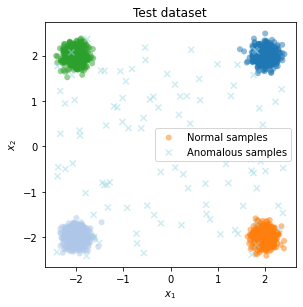

In [105]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

#### Z Test dataset

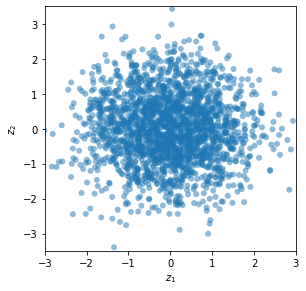

In [106]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

### Testing

In [107]:
feed_dict = {x: X_np_data_test, z:Z_np_data_test}
imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)

score_dz = sess.run(mahalanobis_dis_z, feed_dict=feed_dict)
score_dxx = sess.run(x_sigmoid_real + x_sigmoid_fake, feed_dict=feed_dict)

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims=False)
print(score)
def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)

[0.6536542 0.6813539 0.9690038 ... 0.9998968 0.1974533 1.7163848]


kernel estimation

In [108]:
from sklearn.neighbors import KernelDensity
import numpy as np
feed_dict_train = {x: X_dataset, z:Z_dataset}
imz_train = sess.run(q_z, feed_dict=feed_dict_train)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(imz_train)
score_kernel=kde.score_samples(imz)
print(score_kernel)

[-1.09074721 -1.08507569 -1.50706609 ... -2.46926956 -2.7990447
 -2.92836529]


hand written digit

best bandwidth: 3.79269019073225


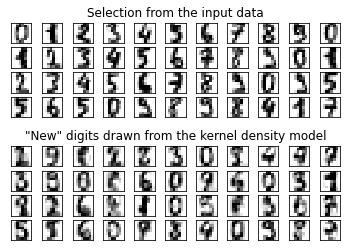

In [109]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(
            real_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(
            new_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)

ax[0, 5].set_title("Selection from the input data")
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

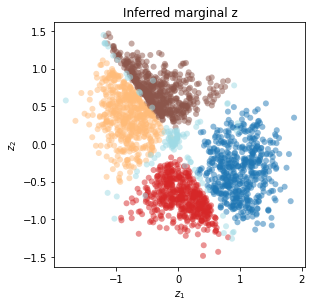

In [110]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

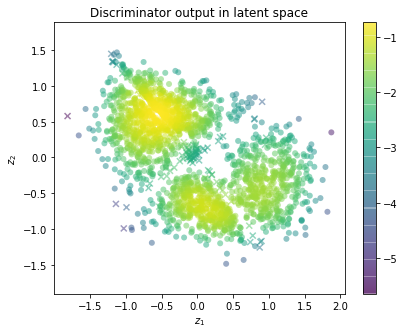

In [111]:
import matplotlib as mpl
## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score_kernel#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

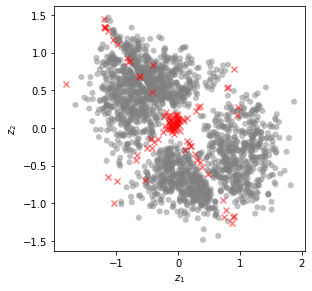

In [112]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

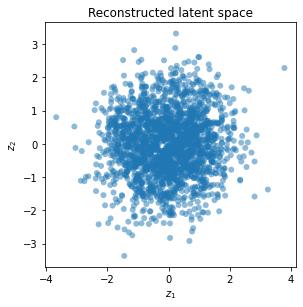

In [113]:
##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

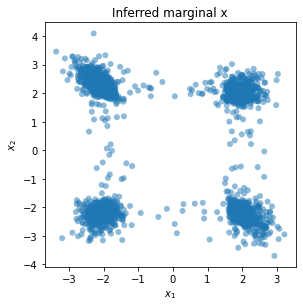

In [114]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

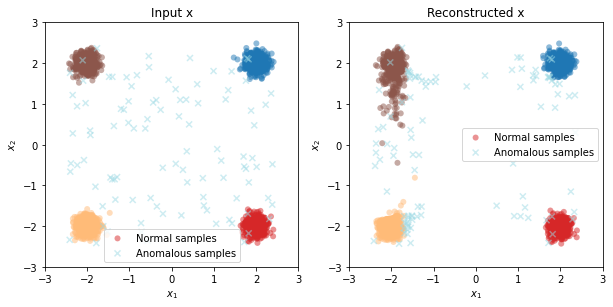

In [115]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

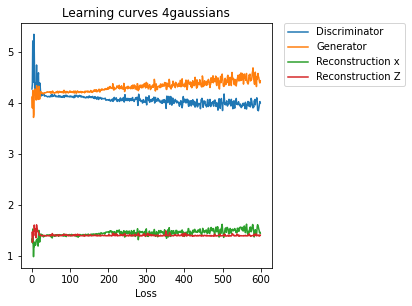

In [116]:
## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()